# HOUSE PRICES REGRESSION

In [110]:
# import relevant packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import warnings

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import mutual_info_regression

from IPython.display import display, HTML

# ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [111]:
train = pd.read_csv(r'C:\Users\acer\Documents\Projek Analisis Data\house-prices-advanced-regression-techniques\train.csv')
test = pd.read_csv(r'C:\Users\acer\Documents\Projek Analisis Data\house-prices-advanced-regression-techniques\test.csv')

In [112]:
# create a copy of train data
df = train.copy()
df_test = test.copy()

In [113]:
# categorized data type based on unique value
def categorize_columns(df):
    categorical = []
    numerical = []

    columns = list(df.columns)

    for col in columns:
        length = len(df[col].unique())
        if (length > 1 and length < 26):
            categorical.append(col)
            df[col] = df[col].astype("category")
        else:
            numerical.append(col)

    return categorical, numerical

categorical, numerical = categorize_columns(df)

pprint.pprint(categorical, compact=True)
print("\n Length of categorical list: {} \n".format(len(categorical)))
pprint.pprint(numerical, compact=True)
print("\n Length of numerical list: {}".format(len(numerical)))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch',
 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
 'SaleType', 'SaleCondition']

 Length of categorical list: 61 

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBs

In [114]:
# scrollable table
def create_scrollable_table(df, title):
    # Convert the summary statistics to an HTML table
    html_table = df.to_html()
    # Wrap the HTML table inside a scrollable div
    scrollable_html_table = f'<h3>{title}</h3><div style="height: 200px; overflow-y: scroll;">{html_table}</div>'
    # Return the scrollable HTML table
    return scrollable_html_table

In [115]:
# numerical features' summary statistics
numerical_features = df.select_dtypes(include=[np.number])
summary_stats_numerical = numerical_features.describe().T
html_numerical = create_scrollable_table(summary_stats_numerical,'Summary statistics for numerical features')
display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0


In [116]:
# categorical features' summary statistics
categorical_features = df.select_dtypes(include=['object', 'category'])
summary_stats_categorical = categorical_features.describe().T
html_categorical = create_scrollable_table(summary_stats_categorical, 'Summary statistics for categorical features')
display(HTML(html_categorical))

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


In [117]:
# null values
missing_values = (df.isnull().sum())
missing_values_filtered = missing_values[missing_values > 0]
missing_values_filtered

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [118]:
def find_missing_value_columns(data, percent):
    train_mv = 100 * data.isnull().sum() / len(data)
    train_mv = pd.DataFrame(train_mv, columns=['% Missing Value'])
    
    filtered_data = train_mv.loc[train_mv['% Missing Value'] > percent]
    
    return filtered_data.sort_values(by='% Missing Value', ascending=False)

filtered_missing_data = find_missing_value_columns(train,40)
print(filtered_missing_data)

             % Missing Value
PoolQC             99.520548
MiscFeature        96.301370
Alley              93.767123
Fence              80.753425
MasVnrType         59.726027
FireplaceQu        47.260274


In [119]:
filtered_missing_data2 = find_missing_value_columns(df_test,40)
print(filtered_missing_data2)

             % Missing Value
PoolQC             99.794380
MiscFeature        96.504455
Alley              92.666210
Fence              80.123372
MasVnrType         61.274846
FireplaceQu        50.034270


In [120]:
# rows with null value columns greater than 13
rows_with_null = df[df.isnull().sum(axis=1) >  13]
html_rows_with_null = create_scrollable_table(rows_with_null, 'Rows with null value columns greater than 13')
display(HTML(html_rows_with_null))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,NaN,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
520,521,190,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,7,1900,2000,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseA,694,600,0,1294,0,0,2,0,3,2,TA,7,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,220,114,210,0,0,0,NaN,NaN,NaN,0,8,2008,WD,Normal,106250
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
705,706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,2Story,4,5,1930,1950,Hip,CompShg,VinylSd,Wd Shng,NaN,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,SBrkr,372,720,0,1092,0,0,2,0,3,2,Fa,7,Mod,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
1011,1012,90,RL,75.0,9825,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1965,1965,Hip,CompShg,AsphShn,AsphShn,NaN,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,SBrkr,1664,0,0,1664,0,0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,100000
1179,1180,20,RL,77.0,8335,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,5,1954,1954,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Gd,Y,SBrkr,1124,0,0,1124,0,0,1,0,3,1,TA,5,Min2,1,Gd,NaN,NaN,NaN,0,0,NaN,NaN,N,0,36,190,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,93000
1218,1219,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,4,5,1947,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Gd,N,SBrkr,672,240,0,912,0,0,1,0,2,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,80500


In [121]:
# index of the rows which have null values more than 13
rows_index_with_null = rows_with_null.index
rows_index_with_null

Index([39, 520, 533, 705, 1011, 1179, 1218], dtype='int64')

In [122]:
mi_df = df.copy()

In [123]:
# Numerical and categorical encoding
def encoding_numeric_categoric(dataframe):
    numerical_features = dataframe.select_dtypes([np.number])
    categorical_features = dataframe.select_dtypes(["object", "category"])

    # Fill null in numerical features
    for col in numerical_features:
        dataframe[col].fillna(dataframe[col].median(), inplace = True)
    # Label encoding for categorical features
    for col in categorical_features:
        dataframe[col], _ = dataframe[col].factorize()

In [124]:
encoding_numeric_categoric(mi_df)
mi_y = mi_df.pop("SalePrice")

In [125]:
def make_mi_score(X, y):
    mi_score = mutual_info_regression(X, y)
    mi_features = pd.Series(mi_score, name = "MI Score", index = X.columns).sort_values(ascending = False)
    return mi_features

mi_score = make_mi_score(mi_df, mi_y)

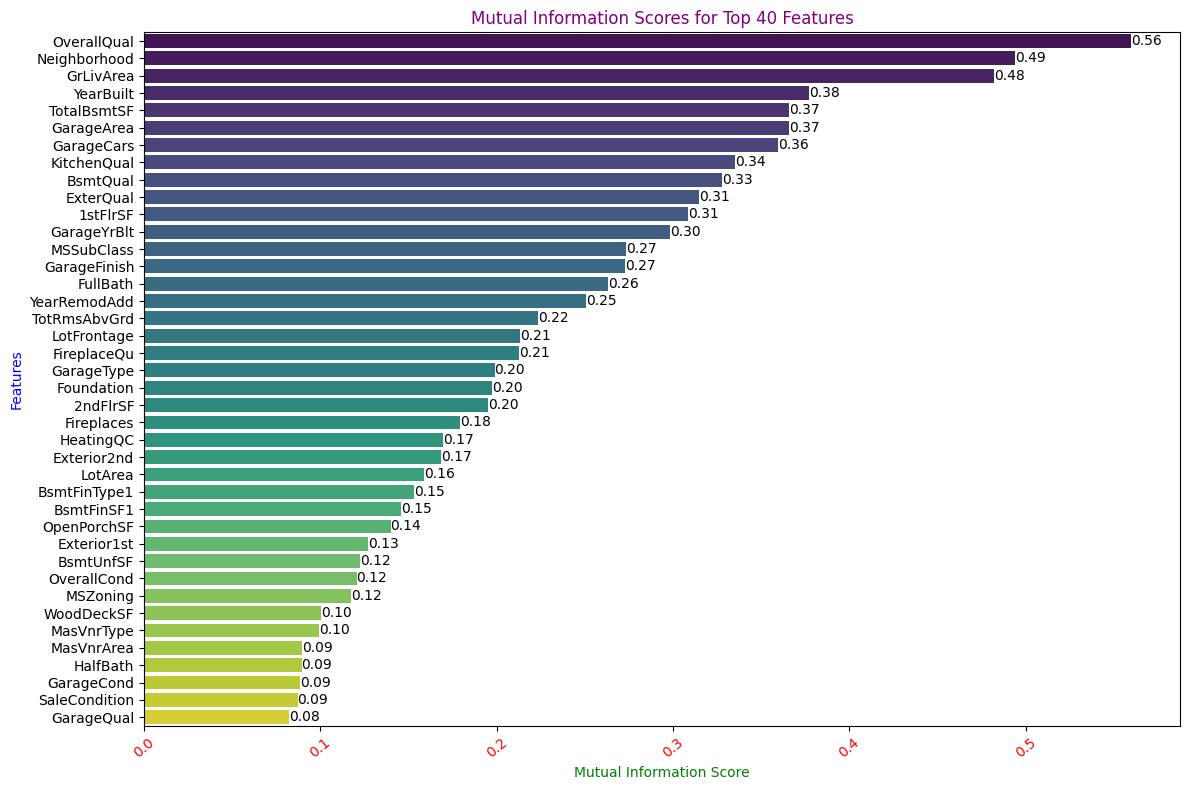

In [126]:
def plot_mi_score(score):
    # Number of features
    top_n = 40

    # Top features
    top_features = score[:top_n]

    # Define a colorful color palette for the bars
    colors = sns.color_palette('viridis', n_colors=len(top_features))

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_features.values, y=top_features.index, orient='h', palette=colors)
    plt.title('Mutual Information Scores for Top {} Features'.format(top_n), color='purple')
    plt.xlabel('Mutual Information Score', color='green')
    plt.ylabel('Features', color='blue')
    plt.xticks(rotation=40, color='red')

    # Add the value labels to the bars
    for index, value in enumerate(top_features.values):
        plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

    plt.tight_layout()  
    return plt.show()

plot_mi_score(mi_score)

In [127]:
def top_numeric_categoric(features, df):
    top_numerical_features = df[features.index].select_dtypes([np.number])
    top_categorical_features = df[features.index].select_dtypes(["object", "category"])

    top_numerical_columns = top_numerical_features.columns
    top_categorical_columns = top_categorical_features.columns

    return top_numerical_columns, top_categorical_columns

Top_features = mi_score[:40]
top_numeric, top_categoric = top_numeric_categoric(Top_features, df)

print("Top numeric features:", top_numeric, end="\n\n")
print("Top categoric features", top_categoric)

Top numeric features: Index(['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       'GarageYrBlt', 'YearRemodAdd', 'LotFrontage', '2ndFlrSF', 'LotArea',
       'BsmtFinSF1', 'OpenPorchSF', 'BsmtUnfSF', 'WoodDeckSF', 'MasVnrArea'],
      dtype='object')

Top categoric features Index(['OverallQual', 'Neighborhood', 'GarageCars', 'KitchenQual', 'BsmtQual',
       'ExterQual', 'MSSubClass', 'GarageFinish', 'FullBath', 'TotRmsAbvGrd',
       'FireplaceQu', 'GarageType', 'Foundation', 'Fireplaces', 'HeatingQC',
       'Exterior2nd', 'BsmtFinType1', 'Exterior1st', 'OverallCond', 'MSZoning',
       'MasVnrType', 'HalfBath', 'GarageCond', 'SaleCondition', 'GarageQual'],
      dtype='object')


In [128]:
# convert the pandas Index objects to Python lists
top_numerics = list(top_numeric)
top_categoric = list(top_categoric)

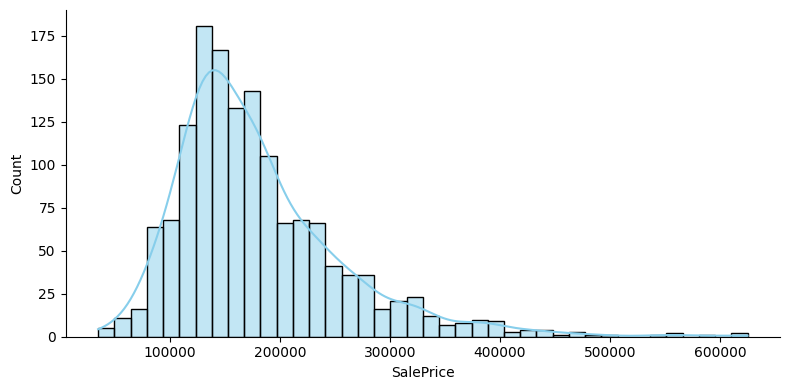

In [129]:
# Define the upper bound value for zooming in
upper_bound = 700000
sns.displot(df.query('SalePrice < @upper_bound')['SalePrice'], kde=True, color='skyblue', height=4, aspect=2)

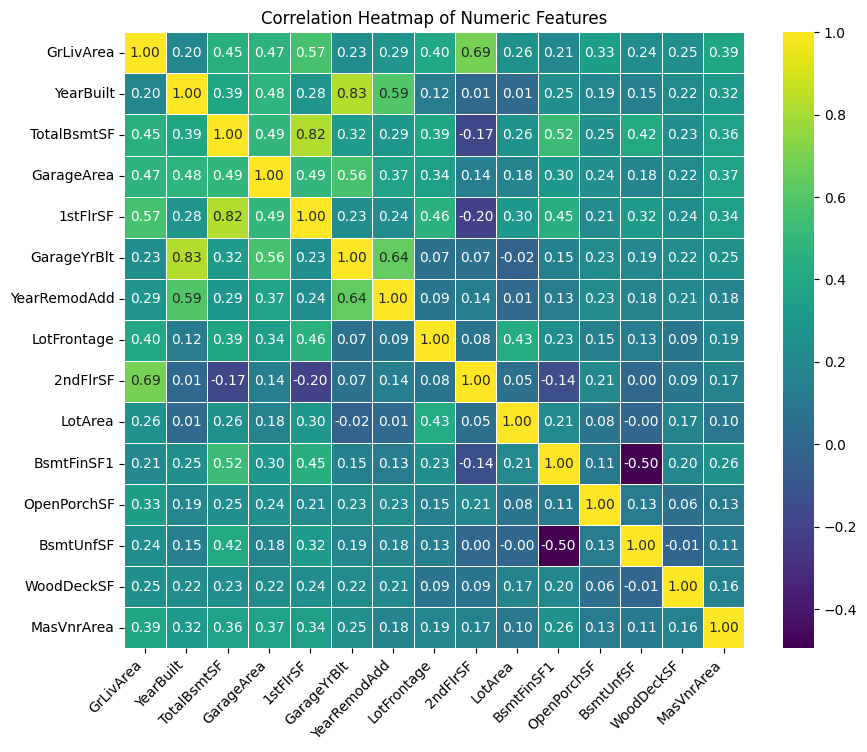

In [130]:
# Compute the correlation matrix for the numeric features
corr_matrix = df[top_numerics].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5, fmt=".2f")

# Set plot title
plt.title('Correlation Heatmap of Numeric Features', fontsize=12)
plt.xticks(rotation=45 ,ha='right')
# Show the plot
plt.show()

Multicollinearity test

In [131]:
def multicollinearity(matrix):
    # Set a threshold for high correlation
    threshold_pos = 0.80
    threshold_neg = -0.80

    # Find pairs of features with high positive correlation
    high_corr_positive = (matrix > threshold_pos) & (matrix < 1.0)

    # Find pairs of features with high negative correlation
    high_corr_negative = (matrix < threshold_neg) & (matrix > -1.0)

    # Combine both dataframes to get all pairs with high correlation (positive and negative)
    high_corr_pairs = high_corr_positive | high_corr_negative

    # Get the feature pairs with high correlation and their correlation values
    pairs_with_high_corr = [(i, j, matrix.loc[i, j]) for i in high_corr_pairs.columns for j in high_corr_pairs.index if high_corr_pairs.loc[i, j]]

    # Print the pairs of features with their correlation values
    for pair in pairs_with_high_corr:
        print(f"Features: {pair[0]}, {pair[1]} - Correlation: {pair[2]}")

corr_matrix = mi_df.corr()
multicollinearity(corr_matrix)

Features: TotalBsmtSF, 1stFlrSF - Correlation: 0.8195299750050339
Features: 1stFlrSF, TotalBsmtSF - Correlation: 0.8195299750050339
Features: PoolArea, PoolQC - Correlation: 0.9166906621198595
Features: PoolQC, PoolArea - Correlation: 0.9166906621198595


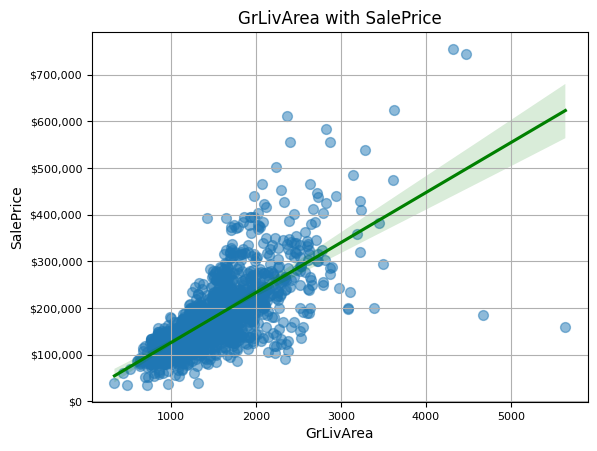

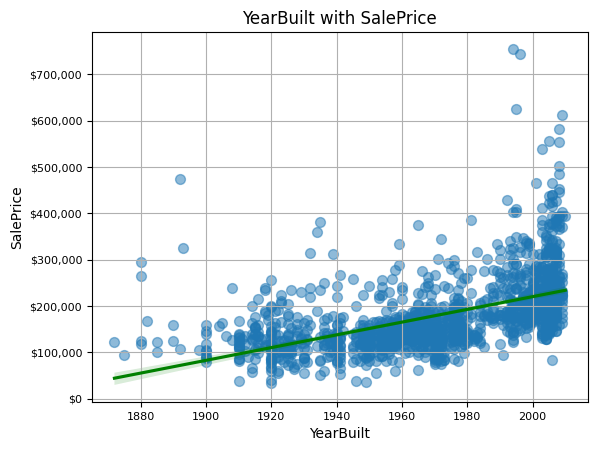

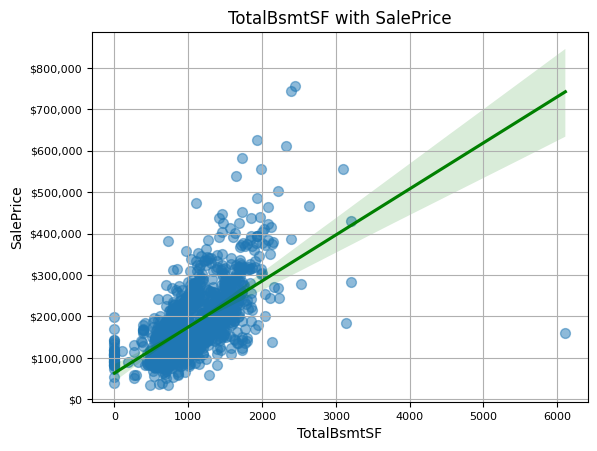

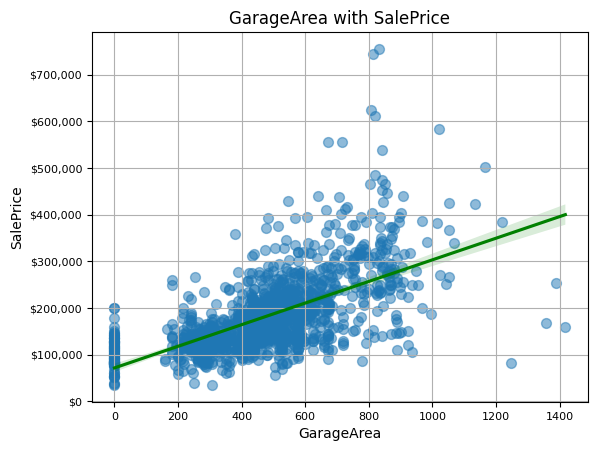

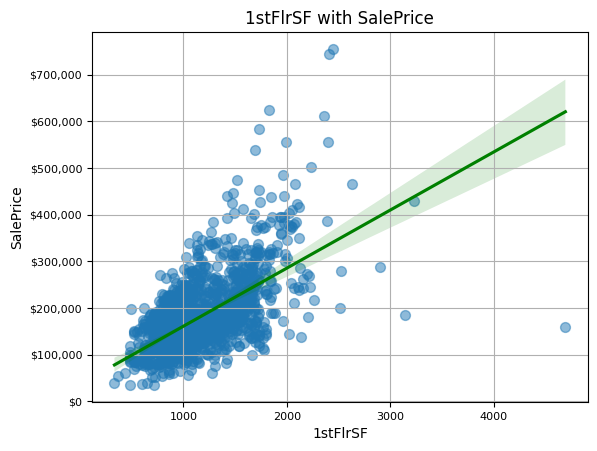

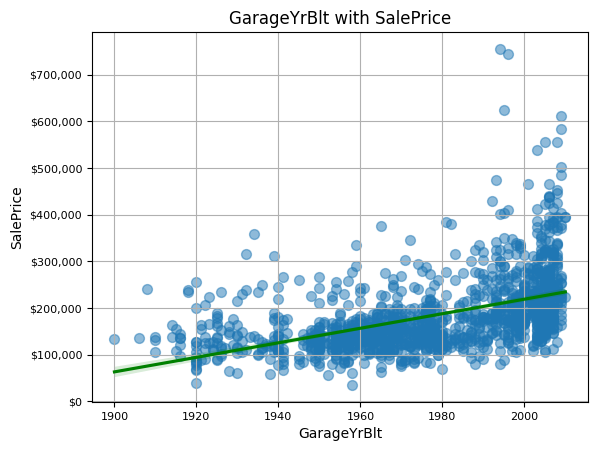

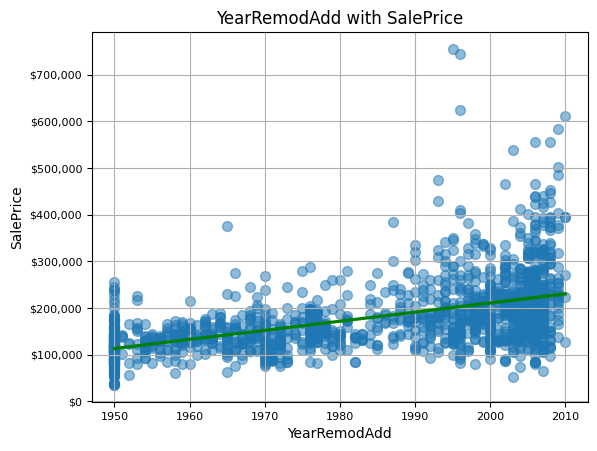

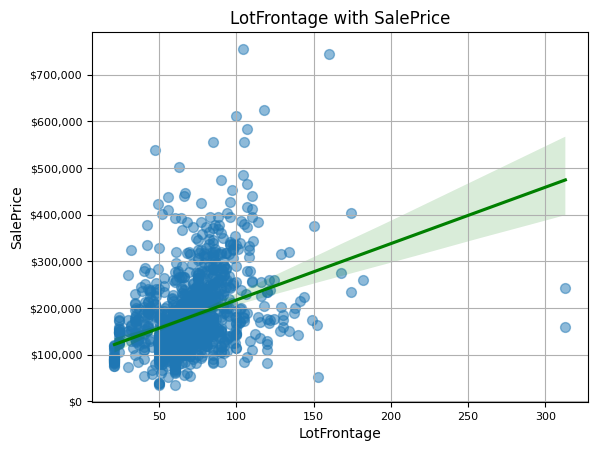

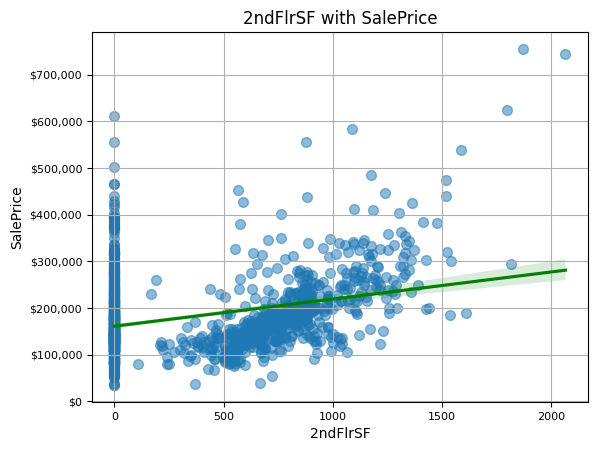

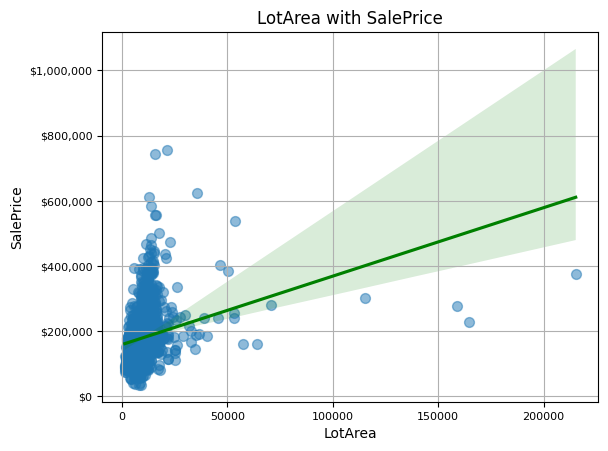

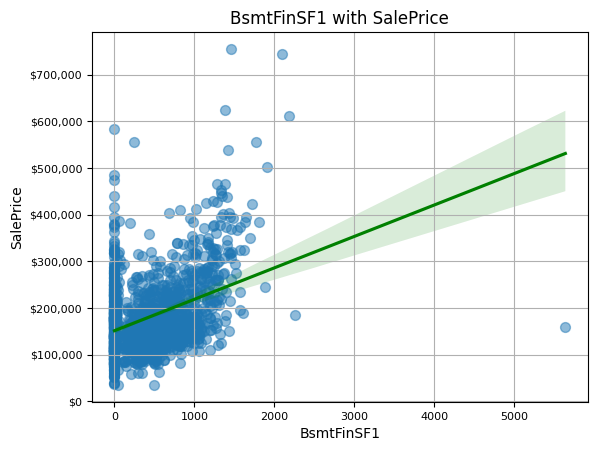

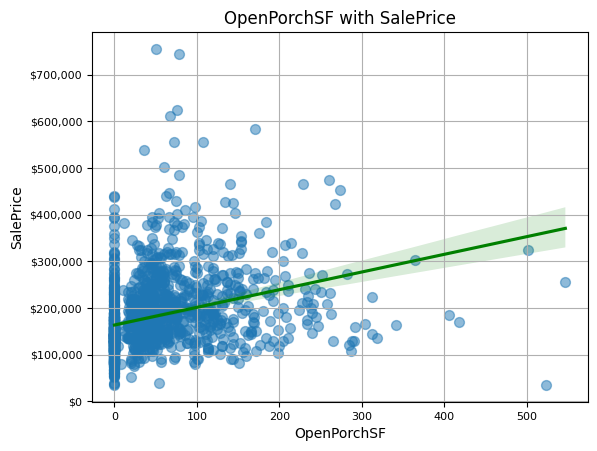

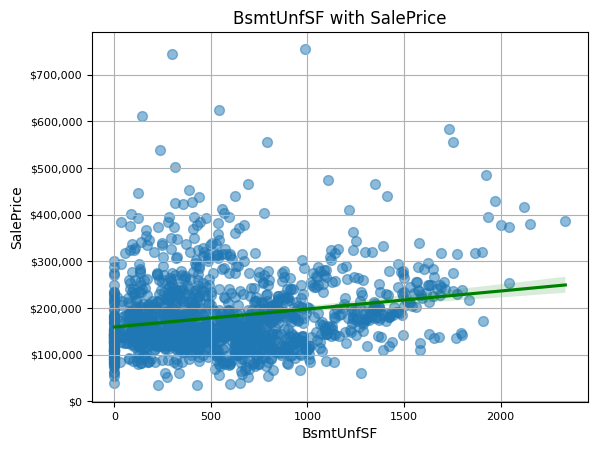

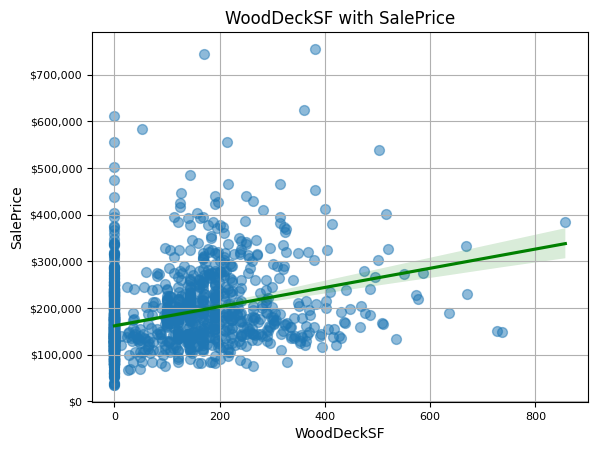

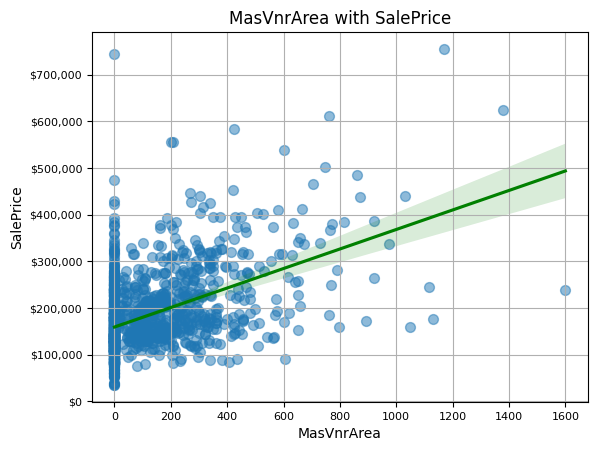

In [132]:
# Scatter plot with regression line for 'Top numeric features' and 'SalePrice'
for features in top_numerics:
    sns.regplot(x=features, y='SalePrice', data=df, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'green'})

    # Set plot title and labels
    plt.title(f'{features} with SalePrice', fontsize=12)
    plt.xlabel(features, fontsize=10)
    plt.ylabel('SalePrice', fontsize=10)

    # Customize the grid and ticks
    plt.grid(True)

    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['${:,.0f}'.format(values) for values in y_ticks])
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Show the plot
    plt.show()

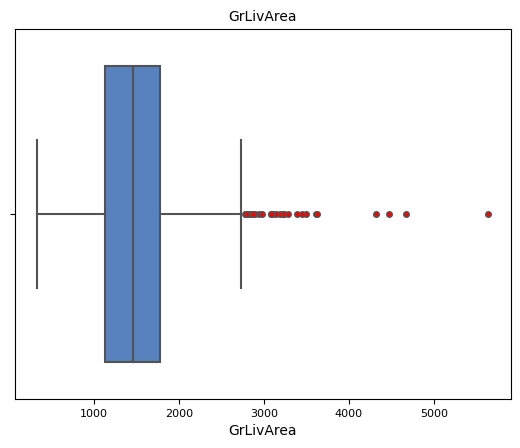

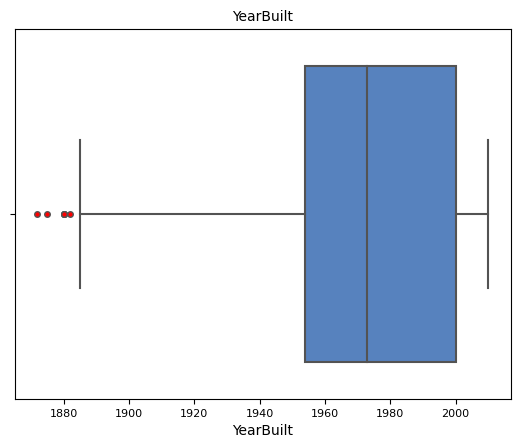

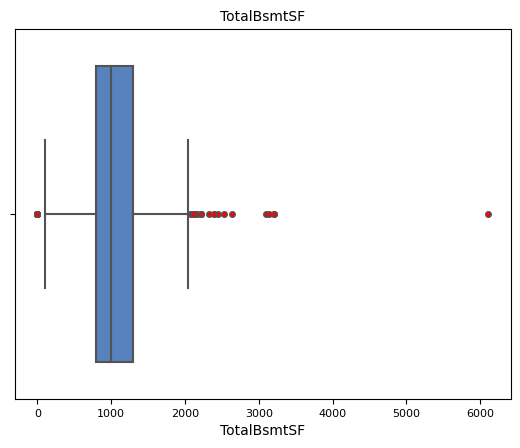

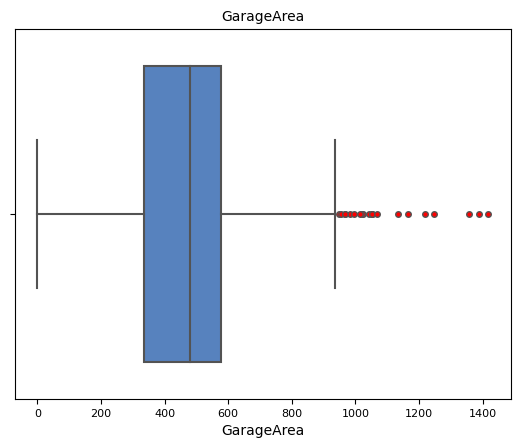

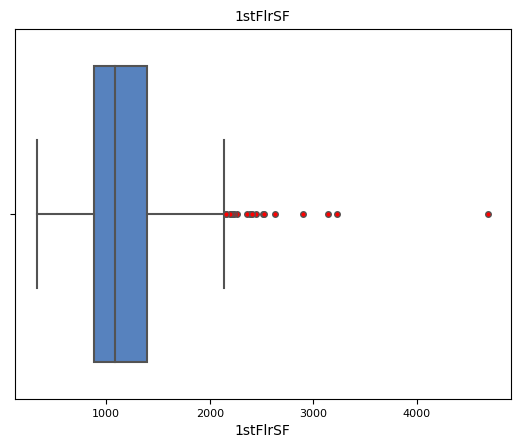

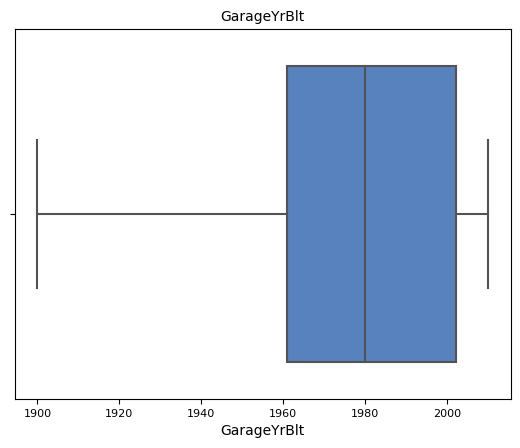

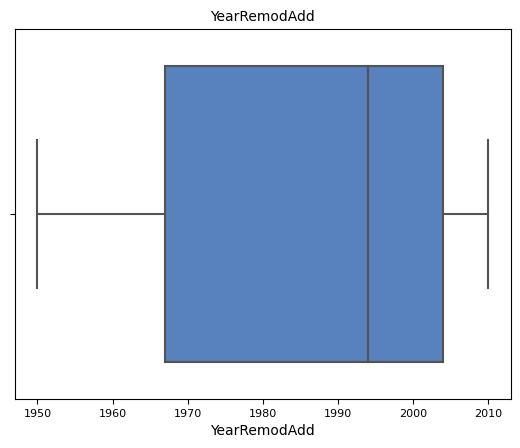

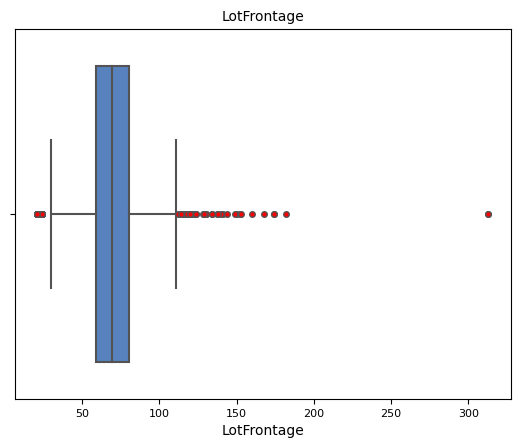

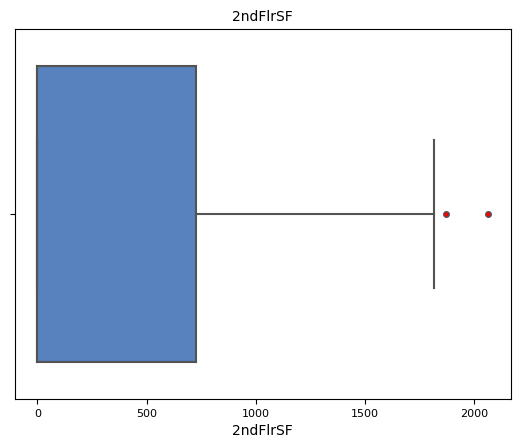

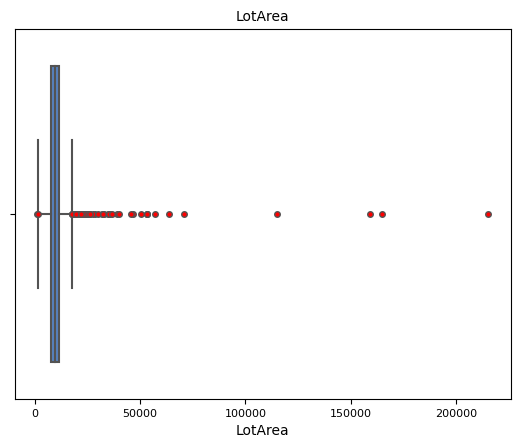

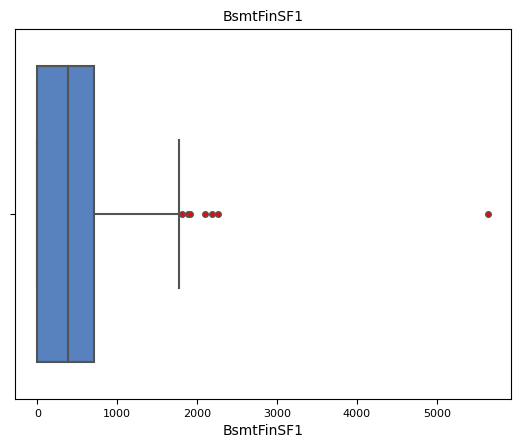

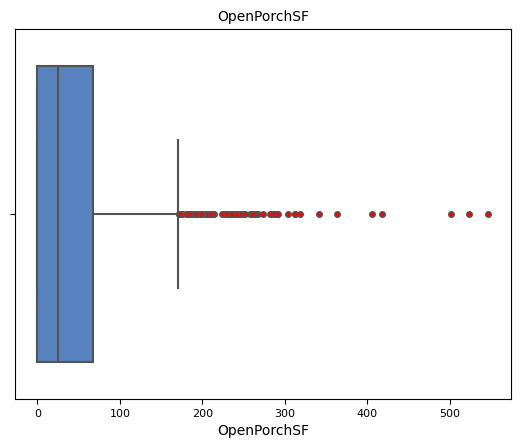

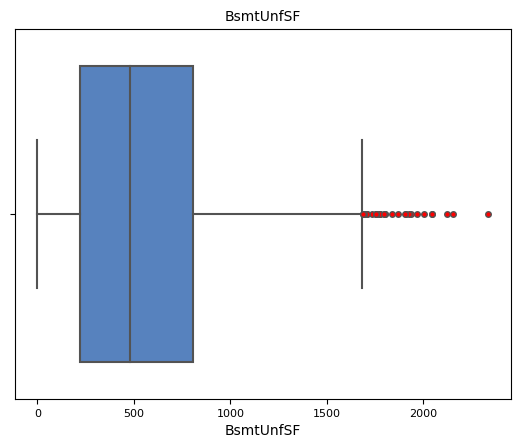

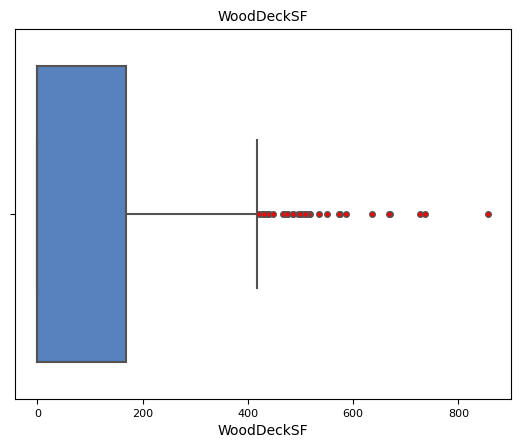

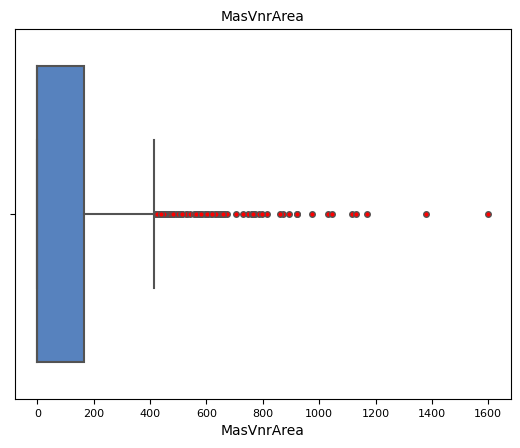

In [133]:
# Box and whicker plot for 'Top numeric features'
for features in top_numerics:
    sns.boxplot(x=features, data=df, color='#467fcf', showfliers=True, flierprops=dict(marker='o', markerfacecolor='red', markersize=4))

    # Set plot title and labels
    plt.title(f'{features}', fontsize=10)
    plt.xlabel(features, fontsize=10)
    plt.xticks(fontsize=8)
    
    # Show the plot
    plt.show()

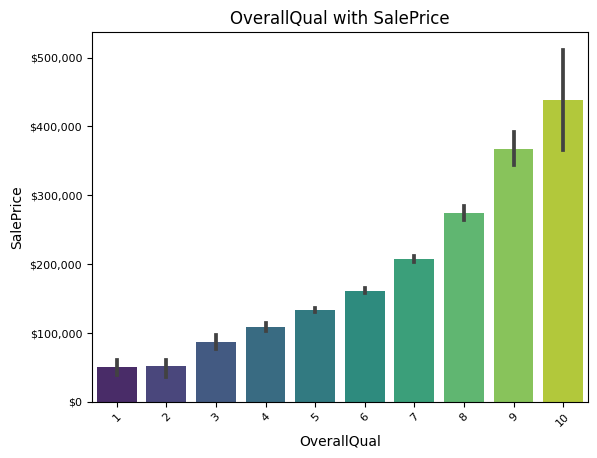

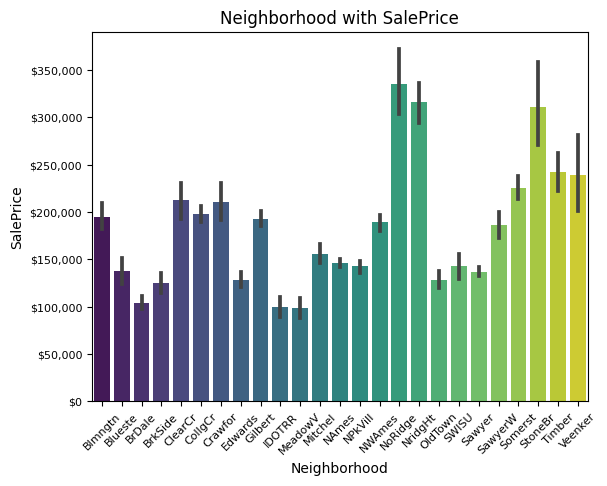

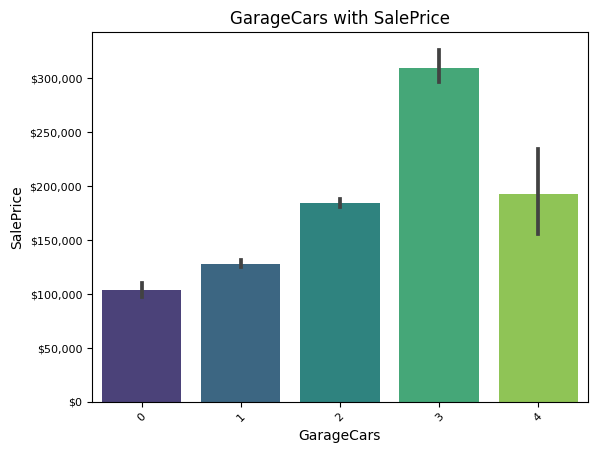

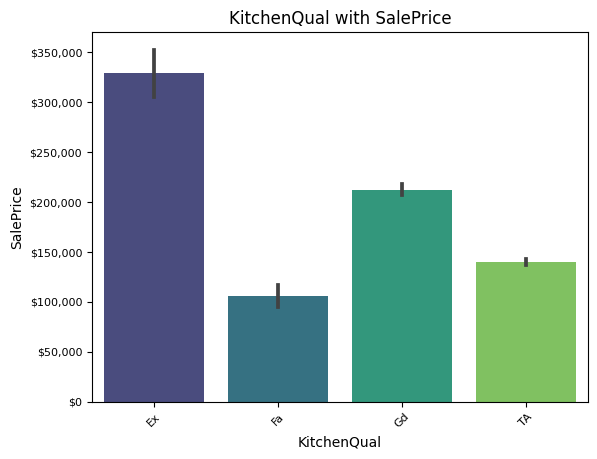

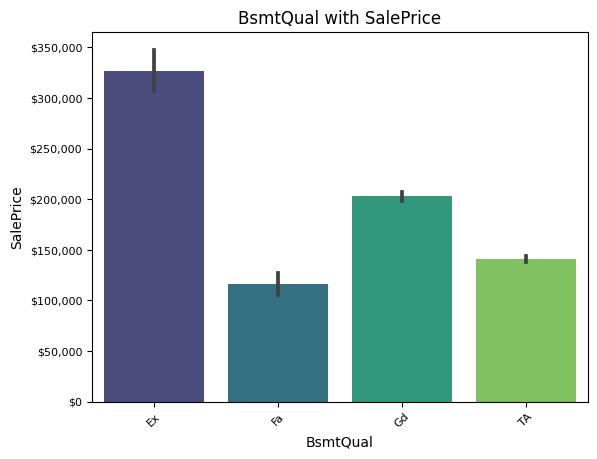

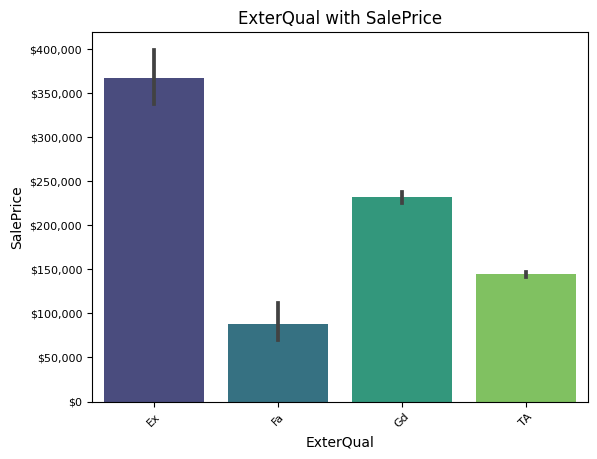

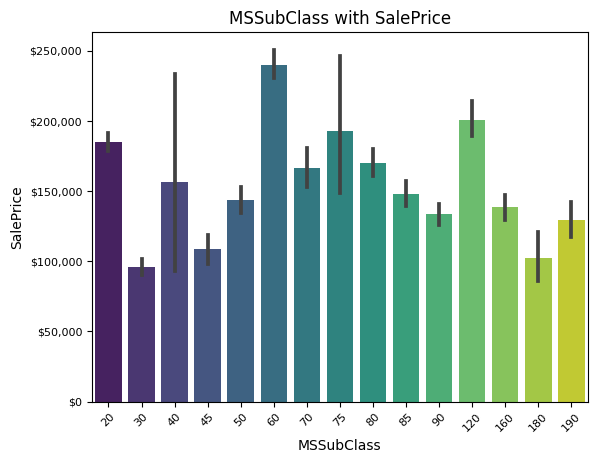

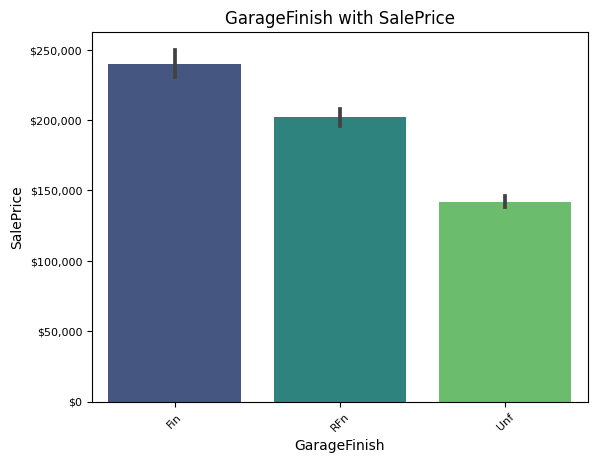

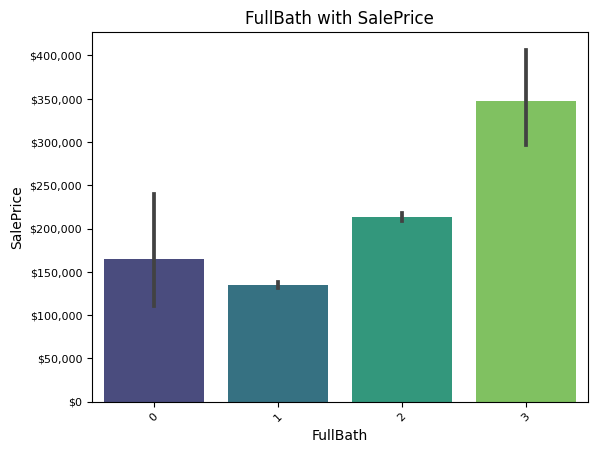

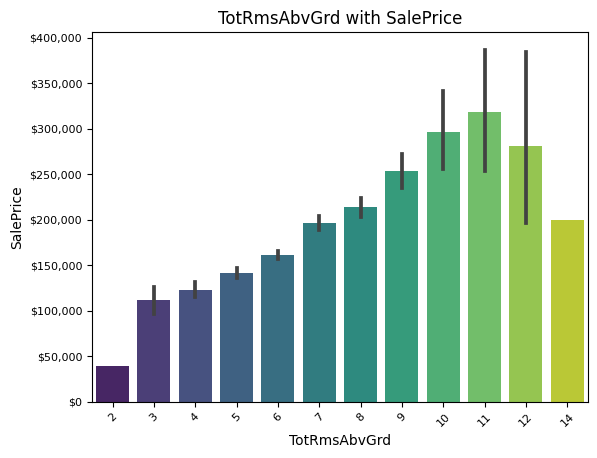

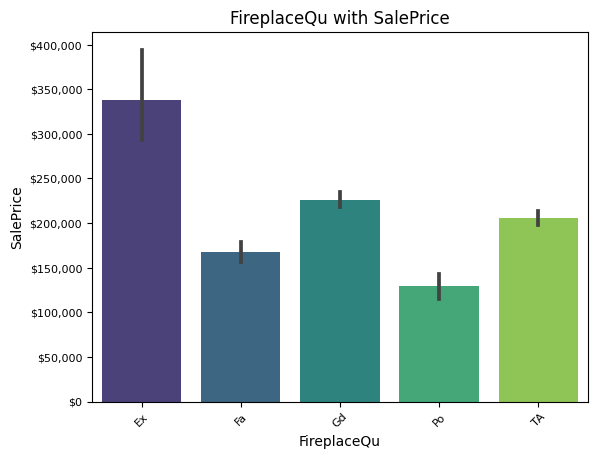

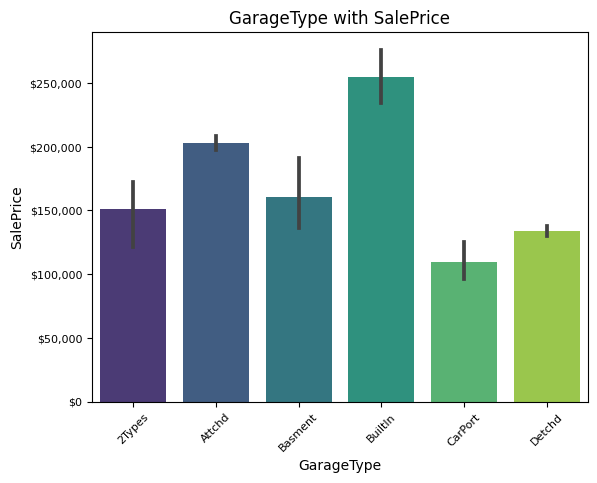

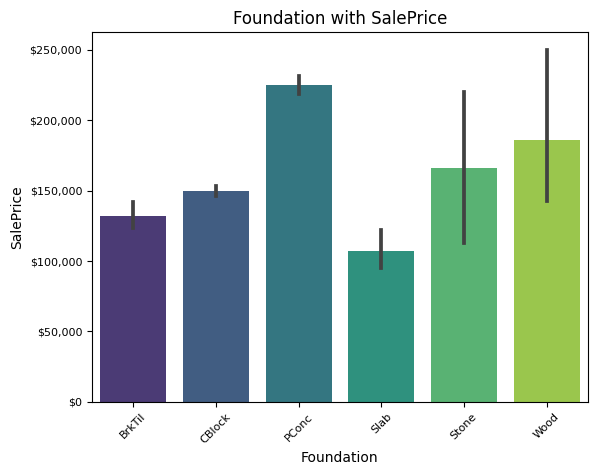

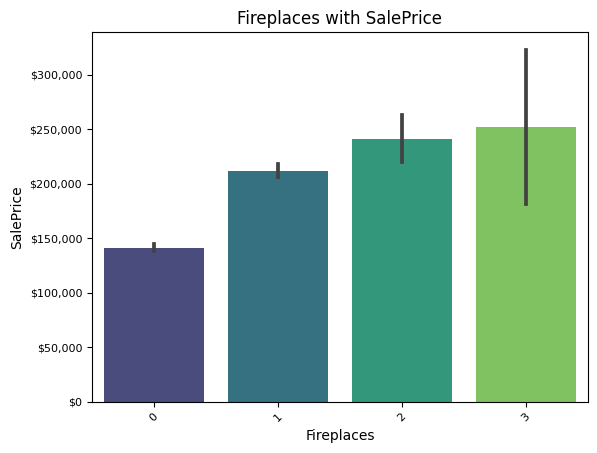

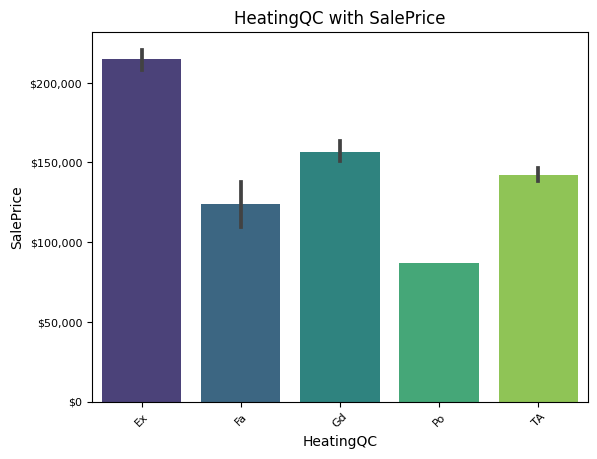

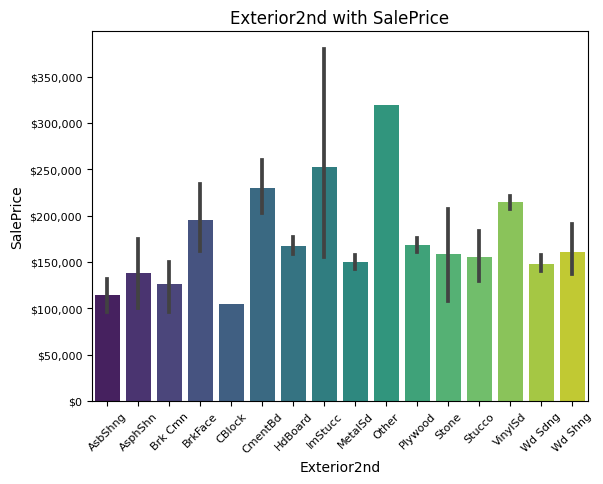

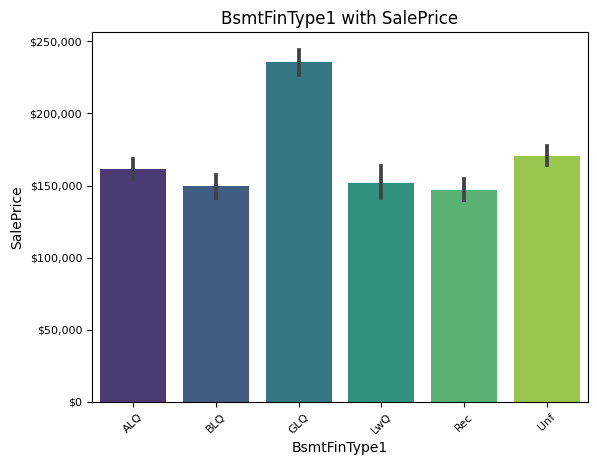

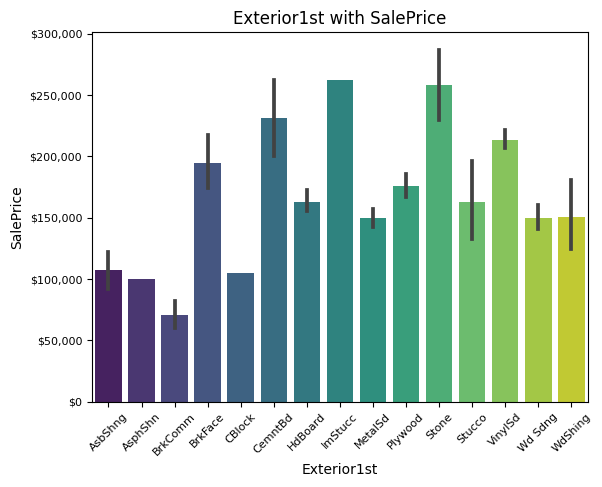

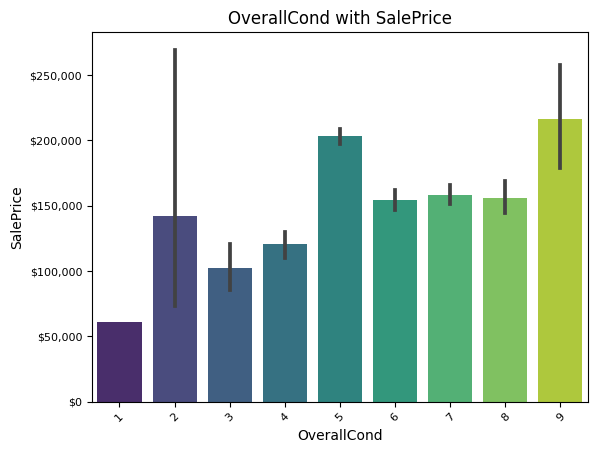

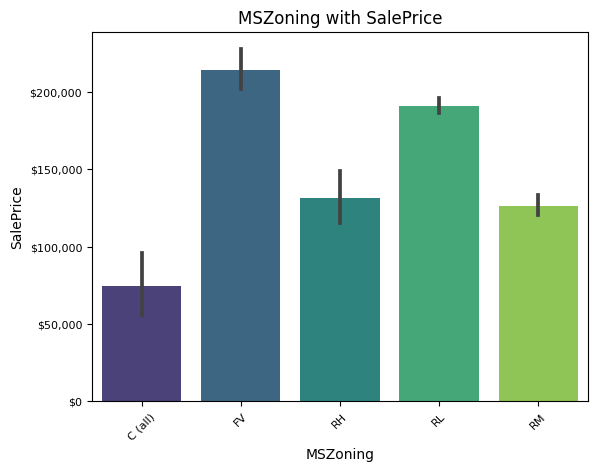

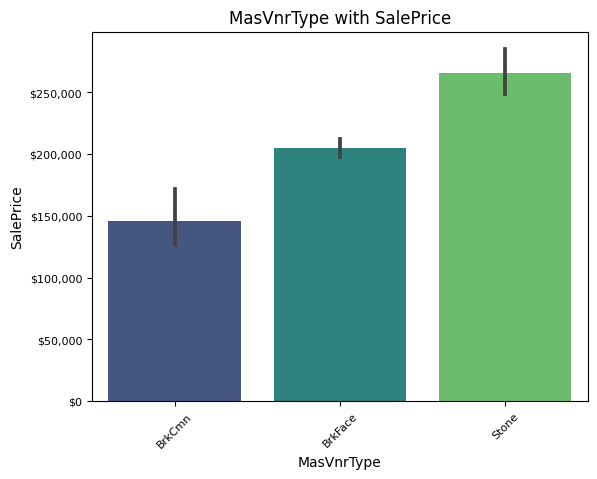

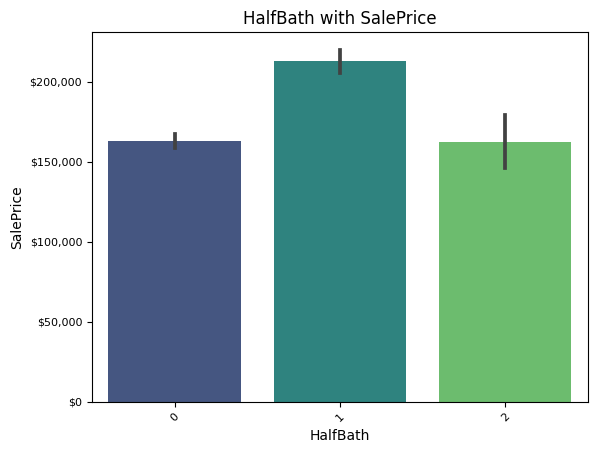

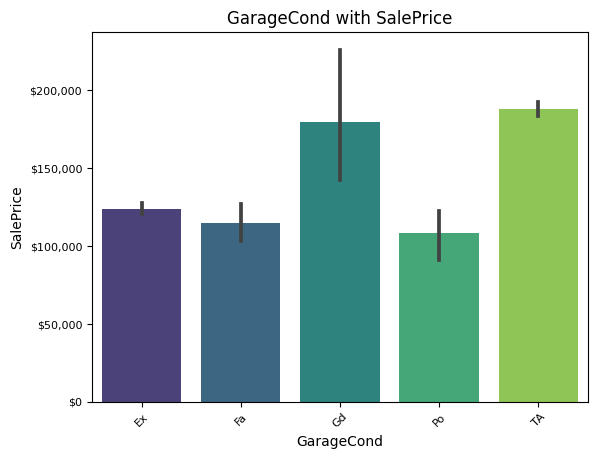

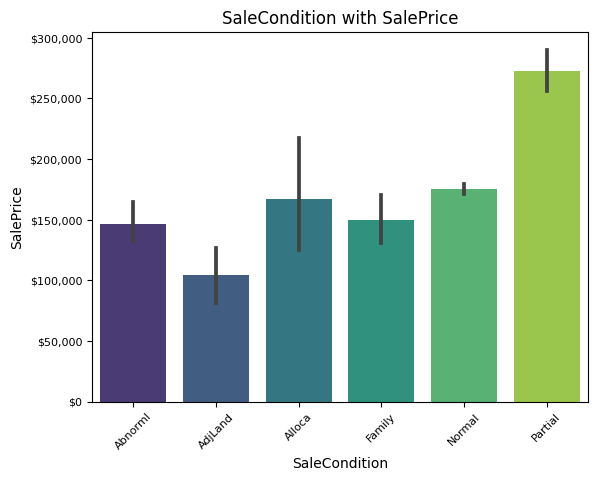

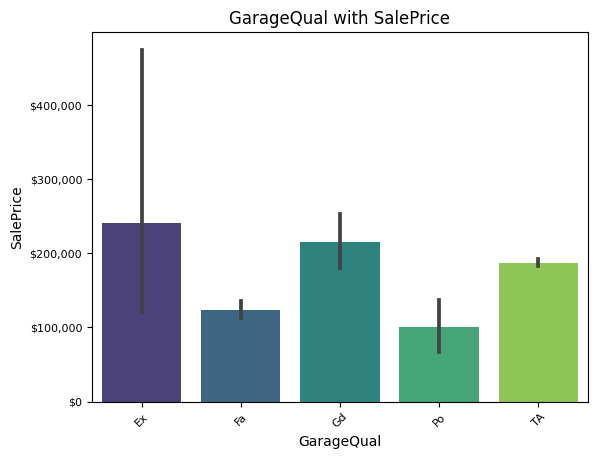

In [134]:
# Bar plot with regression line for 'Top categorical features' and 'SalePrice'
for features in top_categoric:
    sns.barplot(x=features, y='SalePrice', data=df, palette='viridis')

    # Set plot title and labels
    plt.title(f'{features} with SalePrice', fontsize=12)
    plt.xlabel(features, fontsize=10)
    plt.ylabel('SalePrice', fontsize=10)

    plt.xticks(rotation=45)

    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['${:,.0f}'.format(values) for values in y_ticks])
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Show the plot
    plt.show()

## DATA ENGINEERING

In [135]:
df_train_pipeline_1 = train.copy()
df_test_pipeline_1 = df_test.copy()

# Drop rows which have null values columns more than 13
df_train_pipeline_1.drop(rows_index_with_null, axis=0, inplace=True)

In [136]:
# columns to be dropped
columns_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']

def final_cleaned(df, df_test, columns_to_drop):

    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    df_test.drop(columns=columns_to_drop, axis=1, inplace=True)

    print("Column count in training dataset: {}".format(len(df.columns)))
    print("Column count in testing dataset: {}".format(len(df_test.columns)))

    categorical_features = df.select_dtypes(include=["object", "category"]).columns
    numerical_features = df.select_dtypes(include=[np.number]).columns

    return categorical_features, numerical_features

In [137]:
categorical_features, numerical_features = final_cleaned(df_train_pipeline_1, df_test_pipeline_1, columns_to_drop)

Column count in training dataset: 76
Column count in testing dataset: 75


In [138]:
# Preprocessing step for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Preprocessing step for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
]) 

numerical_cols = numerical_features
categorical_cols = categorical_features

# Remove the target variable
numerical_cols = numerical_cols.drop("SalePrice")

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ], remainder="passthrough"
)

In [139]:
# Create pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF',...
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))]))])

In [140]:
# Apply the pipeline
X = df_train_pipeline_1.drop("SalePrice", axis=1)
# Normalized the dependent variable
y = np.log(df_train_pipeline_1["SalePrice"])

# fit and transform
X_preprocessed_pipeline1 = pipeline.fit_transform(X)
X_test_preprocessed_pipeline1 = pipeline.transform(df_test_pipeline_1)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## FEATURE ENGINEERING

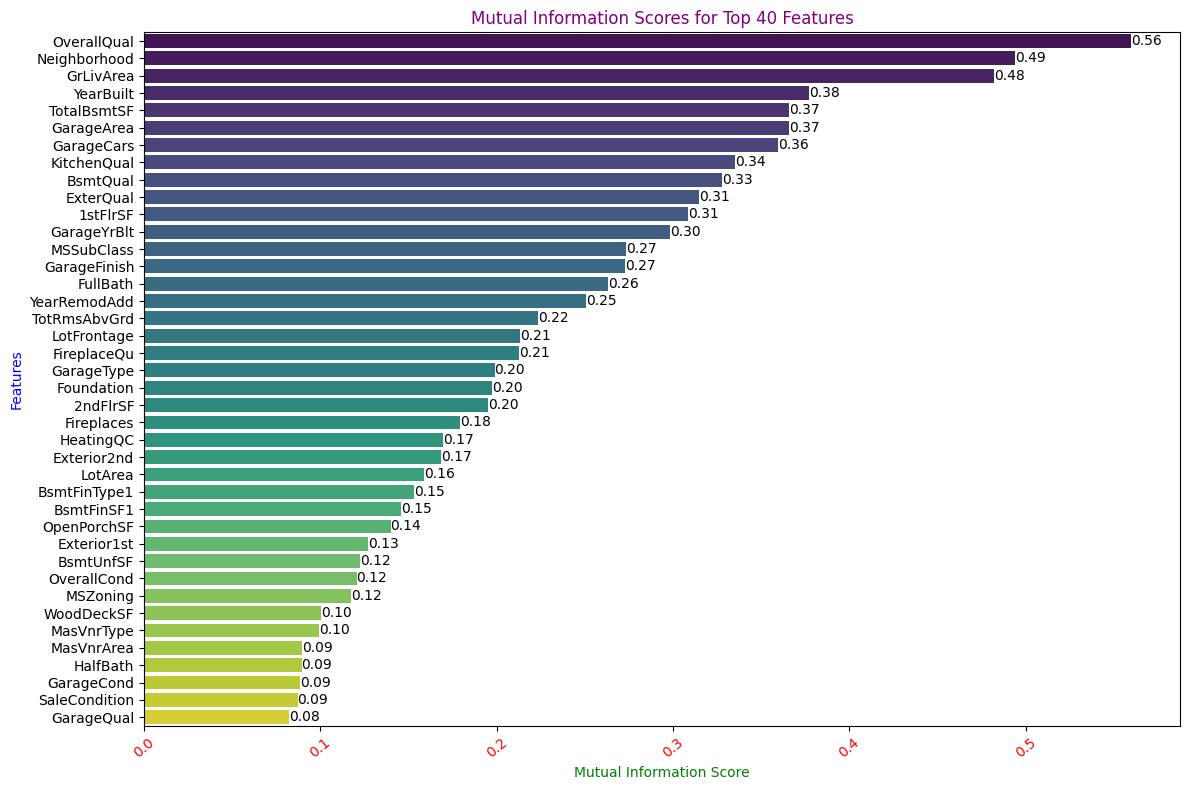

In [141]:
# MI score before the feature engineering
plot_mi_score(mi_score)

In [142]:
def custom_features(df):
    df_out = df.copy()

    df_out['YrSold'] = df_out['YrSold'].astype(int)
    df_out['FullBath'] = df_out['FullBath'].astype(float)
    df_out['BsmtFullBath'] = df_out['BsmtFullBath'].astype(float)
    df_out['HalfBath'] = df_out['HalfBath'].astype(float)
    df_out['BsmtHalfBath'] = df_out['BsmtHalfBath'].astype(float)
    df_out['OverallQual'] = df_out['OverallQual'].astype(int)
    df_out['OverallCond'] = df_out['OverallCond'].astype(int)
    df_out['TotRmsAbvGrd'] = df_out['TotRmsAbvGrd'].astype(int)
    df_out['KitchenAbvGr'] = df_out['KitchenAbvGr'].astype(int)

    df_out['Total_SF'] = (df_out['1stFlrSF'] + df_out['2ndFlrSF'] + df_out['TotalBsmtSF'] + df_out['GarageArea']).astype(float)
    df_out['Total_Bath'] = (df_out['FullBath'] + 0.5 * df_out['BsmtFullBath'] + 0.4 * df_out['HalfBath'] + 0.3 * df_out['BsmtHalfBath']).astype(float)
    df_out['Total_quality'] = (df_out['OverallQual'] + 0.2 * df_out["OverallCond"]).astype(float)
    df_out['Total_AbcGr'] = (df_out['TotRmsAbvGrd'] + df_out['KitchenAbvGr'] + df_out['FullBath'] + df_out['HalfBath']).astype(int)

    return df_out

feature_enginerring_transformer = FunctionTransformer(custom_features)

In [143]:
# Enhance the datset with feature engineering
df_out = custom_features(train)

mi_df_out = df_out.copy()

In [144]:
encoding_numeric_categoric(mi_df_out)
mi_y = mi_df_out.pop("SalePrice")
mi_scores = make_mi_score(mi_df_out, mi_y)

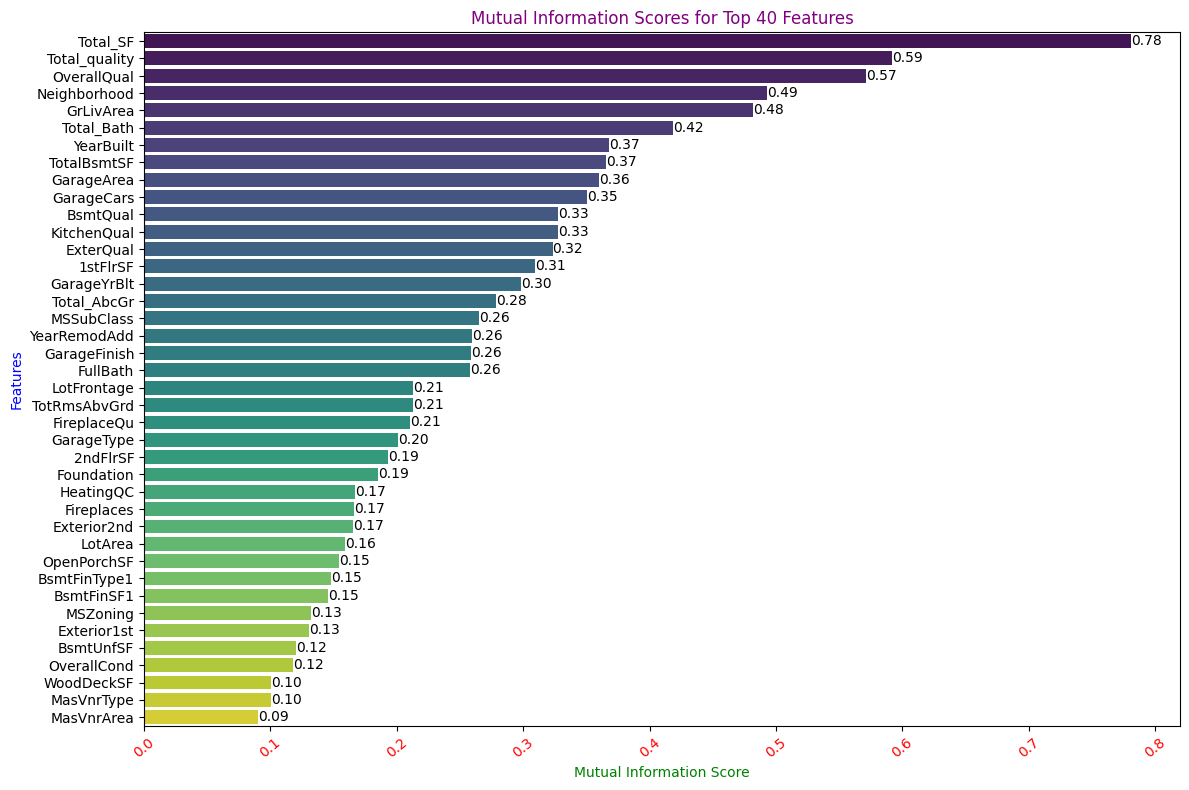

In [145]:
# MI score after feature engineering
plot_mi_score(mi_scores)

In [146]:
df_train_pipeline_2 = df_out.copy()
df_test_pipeline_2 = df_test.copy()

In [147]:
wanted_columns = ['YrSold','FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'OverallQual', 'OverallCond','TotRmsAbvGrd', 
                  'KitchenAbvGr', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GarageArea']

In [148]:
# Exclude unnecessary columns from MI
columns_to_drop = list(set(mi_scores[76:].index) - set(wanted_columns))
pprint.pprint(columns_to_drop, compact=True)

['Id', 'LandSlope', 'RoofMatl', '3SsnPorch', 'MiscVal', 'LowQualFinSF',
 'MoSold', 'PoolArea']


In [149]:
categorical_features, numerical_features = final_cleaned(df_train_pipeline_2, df_test_pipeline_2, columns_to_drop)

Column count in training dataset: 77
Column count in testing dataset: 72


In [150]:
categorical_features = df_train_pipeline_2.select_dtypes(include=["object", "category"]).columns
numerical_features = df_train_pipeline_2.select_dtypes(include=[np.number]).columns

print(f"Total length of categorical features : {(len(categorical_features))}")
print(f"Total length of numerical features : {(len(numerical_features))}")

Total length of categorical features : 41
Total length of numerical features : 36


### Pipeline with Feature Engineering and OneHot Encoding

In [151]:
# Create pipeline with function transformer and the preprocessor

numerical_cols = numerical_features
categorical_cols = categorical_features

# Remove the target variable
numerical_cols = numerical_cols.drop("SalePrice")

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ], remainder="passthrough"
)

pipeline_fe_ohe = Pipeline(steps=[
    ('fe', feature_enginerring_transformer),
    ('preprocessor', preprocessor)
])
pipeline_fe_ohe

Pipeline(steps=[('fe',
                 FunctionTransformer(func=<function custom_features at 0x0000024E0188AFC0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', '...
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))]))])

In [152]:
# Categorical ordinal features
ordinal_features  = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
pprint.pprint(ordinal_features, compact=True)

# Categorical nominal features
nominal_features = list(set(categorical_features) - set(ordinal_features))
pprint.pprint(nominal_features, compact=True)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
 'FireplaceQu', 'GarageQual', 'GarageCond']
['Alley', 'Foundation', 'LotShape', 'BsmtFinType2', 'Condition2', 'MasVnrType',
 'Neighborhood', 'RoofStyle', 'Fence', 'PavedDrive', 'LandContour', 'Heating',
 'PoolQC', 'GarageType', 'GarageFinish', 'BldgType', 'Functional', 'SaleType',
 'Exterior1st', 'MiscFeature', 'BsmtExposure', 'LotConfig', 'MSZoning',
 'HouseStyle', 'Exterior2nd', 'Electrical', 'Condition1', 'Street',
 'SaleCondition', 'Utilities', 'BsmtFinType1', 'CentralAir']


In [153]:
# Ordinal map
ordinal_mapping = ['Ex', 'Gd', 'TA', 'Fa', 'Po']

In [154]:
# Create pipeline with function transformer and the preprocessor

numerical_cols = numerical_features
ordinal_cols = ordinal_features
nominal_cols = nominal_features

# Remove the target variable
numerical_cols = numerical_cols.drop("SalePrice")

# Preprocessing step for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Preprocessing step for ordinal columns
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, categories=[ordinal_mapping for _ in ordinal_cols] ))
])

# Preprocessing step for nominal columns
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse=False))
])

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('onehot', nominal_transformer, nominal_cols)
    ], remainder="passthrough"
)

pipeline_fe_ohe_ordinal = Pipeline(steps=[
    ('fe', feature_enginerring_transformer),
    ('preprocessor', preprocessor)
])

pipeline_fe_ohe_ordinal

Pipeline(steps=[('fe',
                 FunctionTransformer(func=<function custom_features at 0x0000024E0188AFC0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', '...
                                                   'LotShape', 'BsmtFinType2',
                                                   'Condition2', 'MasVnrType',
                                                   'Neighborhood', 'RoofStyle',
                                                   'Fence', 'PavedDrive',
                                                   'LandContour', 'Heating',
                                                   'PoolQC', 'GarageType',
                                                   'GarageFinish', 'BldgType',
                                                   'Functional', 'SaleType',
                                                   'Exterior1st', 'MiscFeature',
                                                   'BsmtExposure', 'LotConfig',
                                                   'MSZoning', 'HouseStyle',
                                                   'Exterior2nd', 'Electrical',
                                                   'Condition1', 'Street',
                                                   'SaleCondition', 'Utilities', ...])]))])

In [155]:
# Apply the second pipeline
X = df_train_pipeline_2.drop("SalePrice", axis=1)
# Normalized the dependent variable
y = np.log(df_train_pipeline_2["SalePrice"])

# fit and transform
X_preprocessed_pipeline2 = pipeline_fe_ohe_ordinal.fit_transform(X)
X_test_preprocessed_pipeline2 = pipeline_fe_ohe_ordinal.transform(df_test_pipeline_2)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [156]:
print(X_preprocessed_pipeline2.shape)

(1460, 243)


## PARAMETER TUNING

In [157]:
model_params = {
    'CatBoost': {
        'model': CatBoostRegressor(),
        'params': {
            'depth': [3],
            'iterations': [6200],  
            'learning_rate': [0.01],
            'l2_leaf_reg': [3],
            'max_leaves': [8],
            'model_size_reg': [0.4],
            'od_wait': [150], 
            'random_seed': [42]
        }
    }
}

In [158]:
# Initialize KFold cross-validation
kf_cv = KFold(n_splits=3, shuffle=True, random_state=0)

In [159]:
best_model_name = None
best_model = None
best_params = None
best_score = float('inf')

for model_name, model in model_params.items():
    grid = GridSearchCV(estimator=model["model"], param_grid=model["params"], cv=kf_cv, scoring="neg_mean_squared_error", return_train_score=False, n_jobs=-1, verbose=2)
    grid.fit(X_preprocessed_pipeline2, y)

    models = model_name
    current_best_score = np.sqrt(-1 * (grid.best_score_))

    print(f"Best parameters for {models} : {grid.best_params_}")
    print(F"Best RMSE for {models} is {current_best_score} \n")

    # Best model with best parameters
    if current_best_score < best_score:
        best_score = current_best_score
        best_model_name = model_name
        best_model = grid.best_estimator_
        best_params = grid.best_params_

print(f"The best model is {best_model_name} with parameters {best_params}")

# Use best model to predcit the SalePrice
y_pred = best_model.predict(X_test_preprocessed_pipeline2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


0:	learn: 0.3969149	total: 3.25ms	remaining: 20.2s
1:	learn: 0.3943827	total: 5.65ms	remaining: 17.5s
2:	learn: 0.3920419	total: 7.9ms	remaining: 16.3s
3:	learn: 0.3895687	total: 10.3ms	remaining: 16s
4:	learn: 0.3872228	total: 12.7ms	remaining: 15.7s
5:	learn: 0.3849296	total: 15.3ms	remaining: 15.8s
6:	learn: 0.3827568	total: 18.4ms	remaining: 16.3s
7:	learn: 0.3806137	total: 21.2ms	remaining: 16.4s
8:	learn: 0.3783456	total: 24ms	remaining: 16.5s
9:	learn: 0.3762441	total: 26.6ms	remaining: 16.4s
10:	learn: 0.3740909	total: 28.9ms	remaining: 16.3s
11:	learn: 0.3720728	total: 31.5ms	remaining: 16.3s
12:	learn: 0.3699240	total: 34.9ms	remaining: 16.6s
13:	learn: 0.3679020	total: 37.1ms	remaining: 16.4s
14:	learn: 0.3657529	total: 39.3ms	remaining: 16.2s
15:	learn: 0.3634993	total: 41.8ms	remaining: 16.1s
16:	learn: 0.3613877	total: 44.3ms	remaining: 16.1s
17:	learn: 0.3593389	total: 46.6ms	remaining: 16s
18:	learn: 0.3573430	total: 49.8ms	remaining: 16.2s
19:	learn: 0.3554204	total: 5

In [160]:
current_best_score

0.12214127304758769

In [161]:
print(X_preprocessed_pipeline2.shape)

(1460, 243)


In [162]:
# Convert SalesPrice back to original values
converted_y_pred = np.exp(y_pred)
y_pred_catboost = pd.DataFrame(converted_y_pred,columns=["Y Pred Catboost"]).round(3)

In [163]:
sub = pd.read_csv(r'C:\Users\acer\Documents\Projek Analisis Data\house-prices-advanced-regression-techniques\sample_submission.csv')
y_sub = sub.drop('Id',axis=1).round(3)

In [164]:
y_pred_catboost.head()


,Y Pred Catboost
0,125889.571
1,158173.908
2,186964.057
3,194171.866
4,184211.167


In [165]:
comparison = pd.concat([y_pred_catboost,y_sub],axis=1)
comparison.head(10)

,Y Pred Catboost,SalePrice
0,125889.571,169277.052
1,158173.908,187758.394
2,186964.057,183583.684
3,194171.866,179317.478
4,184211.167,150730.080
5,167874.090,177150.989
6,175979.332,172070.659
7,164642.255,175110.957
8,180258.770,162011.699
9,125405.635,160726.248


In [166]:
# Create the submission file
df_catboost = test[['Id']].copy()
df_catboost['SalePrice'] = converted_y_pred
df_catboost.to_csv(r'C:\Users\acer\Documents\Projek Analisis Data\house-prices-advanced-regression-techniques\submission_catboost_ohe_ordinal.csv', index=False)

In [167]:
df_catboost.head(15)

,Id,SalePrice
0,1461,125889.570804
1,1462,158173.907653
2,1463,186964.057253
3,1464,194171.866294
4,1465,184211.167283
5,1466,167874.089922
6,1467,175979.332062
7,1468,164642.254705
8,1469,180258.769946
9,1470,125405.635098
